In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

y_train_one_hot = tf.one_hot(y_train, 10)
y_test_one_hot = tf.one_hot(y_test, 10)

In [4]:


def get_autoencoder(encoder_input_size, latent_space_size):
    # encoder
    encoder = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(encoder_input_size,)),
        tf.keras.layers.Dense(latent_space_size, activation='relu')
    ])

    # decoder
    decoder = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(latent_space_size,)),
        tf.keras.layers.Dense(784, activation='relu')
    ])

    # autoencoder
    autoencoder_input = tf.keras.layers.Input(shape=(encoder_input_size,))
    autoencoder = tf.keras.Model(
        autoencoder_input,
        decoder(encoder(autoencoder_input))
    )

    # using SSIM instead of MSE makes the brightness/luminosity more similar, but allows for more one pixel differences, which would generally spike the MSE
    # also much slower (all the reshaping?)
    def SSIMLoss(y_true, y_pred):
        y_true_reshaped = tf.reshape(y_true, (-1, 28, 28, 1))
        y_pred_reshaped = tf.reshape(y_pred, (-1, 28, 28, 1))
        return 1 - tf.reduce_mean(tf.image.ssim(y_true_reshaped, y_pred_reshaped, 1.0))

    autoencoder.compile(
        optimizer='adam',
        loss='mean_squared_error'
        # loss=[SSIMLoss]
    )

    return autoencoder, encoder, decoder

In [53]:
# dimensions
encoder_input_size = 784
latent_space_size = 64
autoencoder, encoder, decoder = get_autoencoder(encoder_input_size, latent_space_size)

history = autoencoder.fit(
    x_train,
    x_train,
    epochs=25,
    batch_size=512,
    validation_data=(x_test, x_test)
)

Epoch 1/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0644 - val_loss: 0.0215
Epoch 2/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0190 - val_loss: 0.0135
Epoch 3/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - val_loss: 0.0109
Epoch 4/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - val_loss: 0.0098
Epoch 5/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 6/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 7/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 8/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 9/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 10/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 11/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 12/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

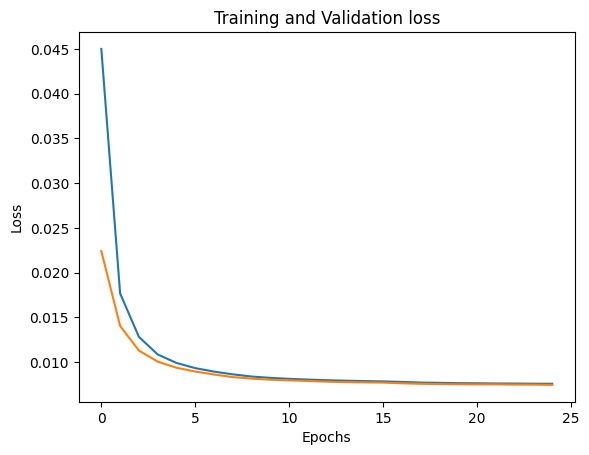

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

[[1.2023479  1.672129   0.945161   1.4050118  1.3507075  2.5661876
  1.8346142  0.6821811  0.5293623  1.4423069  0.2525539  2.1936667
  2.4283783  1.2397579  0.5621054  0.50440335 2.6763382  1.3016644
  2.3188283  1.6584026  1.4443086  1.7882085  1.2059889  2.1926858
  2.3808866  1.980668   2.7930608  4.176678   0.67330235 3.0734327
  1.150434   0.9332802  1.3545723  0.5271867  1.5240031  1.7475793
  2.5223186  2.7030473  1.9681653  0.727304   0.48582643 1.2162211
  2.6310124  1.0928825  0.72418714 1.2765617  0.93619156 2.567094
  2.609058   1.2314132  1.0036588  0.47303686 1.6659312  0.8699863
  0.7556413  1.61967    2.543274   0.42062142 0.7583413  1.7890358
  0.999208   1.3222734  1.8068042  0.62347376]]


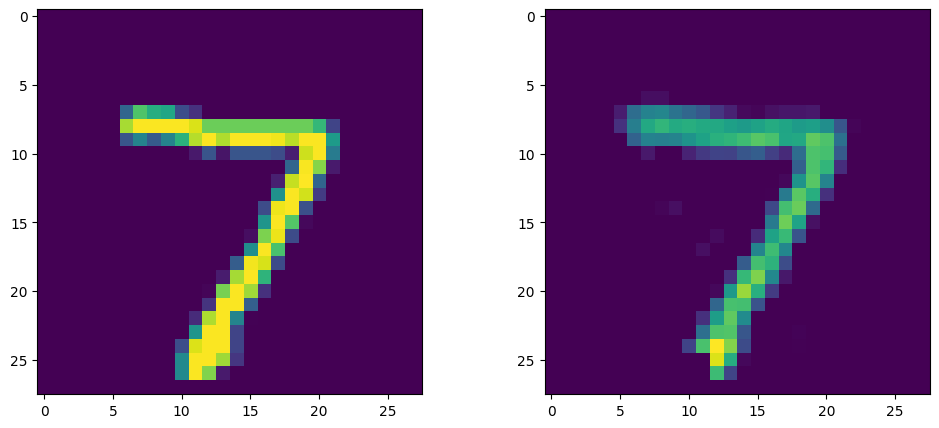

In [49]:
encoding = encoder.predict(x_test[:1], verbose=0)
decoding = decoder.predict(encoding, verbose=0)

print(encoding)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(x_test[0].reshape(28,28))
ax2.imshow(decoding.reshape(28,28))
plt.show();

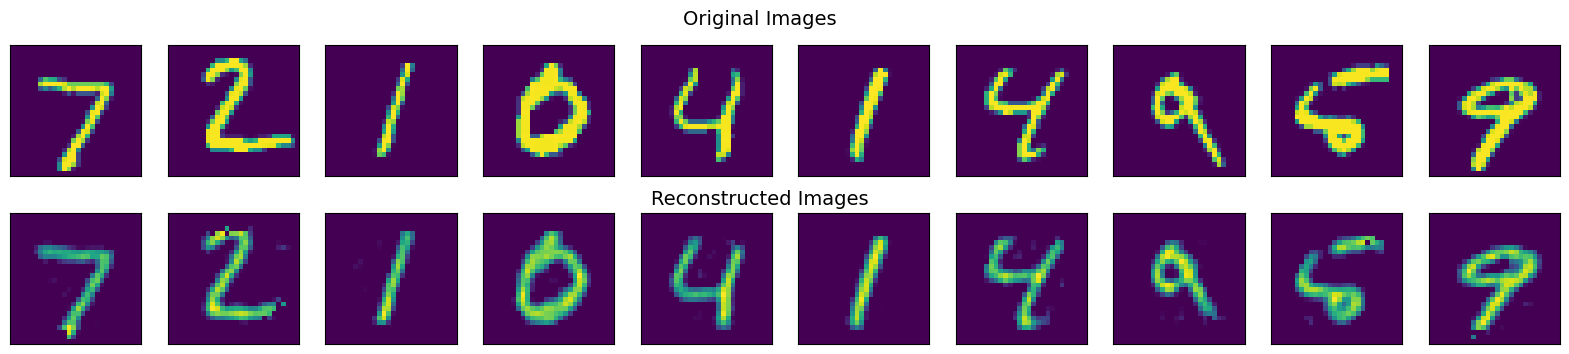

In [50]:
n = 10
reconstructions = autoencoder.predict(x_test[:n], verbose=0)
plt.figure(figsize=(20, 4))

fig.suptitle("Autoencoder Results", fontsize=16)  # Overall figure title
plt.figtext(0.5, 0.92, "Original Images", ha="center", fontsize=14)  # Subtitle for top row
plt.figtext(0.5, 0.47, "Reconstructed Images", ha="center", fontsize=14)  # Subtitle for bottom row

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [55]:
loss = autoencoder.evaluate(x_test, x_test, verbose=0)
loss

0.007209697738289833

Try autoencoders with different sizes of latent spaces

In [6]:
encoder_input_size = 784
latent_space_sizes = [8, 16, 32, 64, 128, 256, 512, 784, 1024]
losses = []

for latent_space_size in latent_space_sizes:
    autoencoder, _, _ = get_autoencoder(encoder_input_size, latent_space_size)

    history = autoencoder.fit(
        x_train,
        x_train,
        epochs=20,
        batch_size=512,
        validation_data=(x_test, x_test),
        verbose=0
    )

    losses.append(autoencoder.evaluate(x_test, x_test, verbose=0))

    print(f"Finished latent space size: {latent_space_size}")

Finished latent space size: 8
Finished latent space size: 16
Finished latent space size: 32
Finished latent space size: 64
Finished latent space size: 128
Finished latent space size: 256
Finished latent space size: 512
Finished latent space size: 784
Finished latent space size: 1024


Losses: [0.036623407155275345, 0.024374375119805336, 0.012684368528425694, 0.0075050233863294125, 0.0044473703019320965, 0.003257622243836522, 0.0026094475761055946, 0.002779588336125016, 0.0031054040882736444]
Latent Space Sizes: [8, 16, 32, 64, 128, 256, 512, 784, 1024]


Text(0.5, 0, 'Latent Space Size')

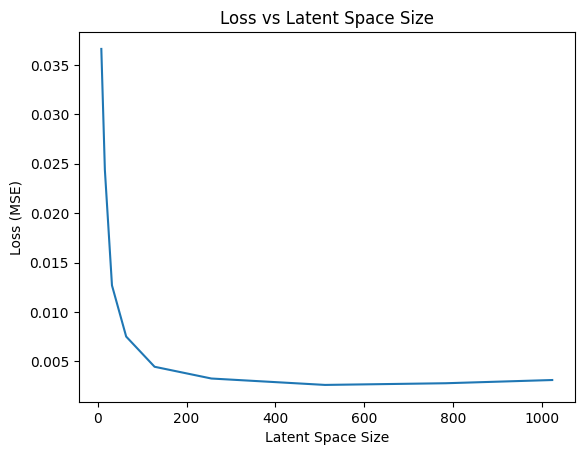

In [7]:
print(f"Losses: {losses}")
print(f"Latent Space Sizes: {latent_space_sizes}")
      
plt.plot(latent_space_sizes, losses)
plt.title("Loss vs Latent Space Size")
plt.ylabel("Loss (MSE)")
plt.xlabel("Latent Space Size")
